# Modeling historical water levels in Moro Cojo Slough

Similar analysis as [tidal_height_flow_navd.ipynb](tidal_height_flow_navd.ipynb). Includes analysis of summer 2015 (before tide gate repairs) and retrospective modeling of historical water levels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import os.path
from physoce import tseries as ts
from physoce_obs import noaatide
from data_paths import water_level_path, tide_gauge_path

In [2]:
# Load NOAA tide gauge data set
tg = noaatide.csv_to_dataframe(tide_gauge_path(),
                      pattern='*.csv')

In [3]:
combined_file = os.path.join(water_level_path(),'Ross_waterlevel_data_combine_time_series.csv')
df = pd.read_csv(combined_file,usecols=[0,3],parse_dates=[0],names=['DateTime_sensor','h_ngvd29'],skiprows=1)

# adjust from PDT to PST where necessary
# manually found deployments that start in Daylight Savings Time
dtime_sensor = np.array(df['DateTime_sensor'])
dsi, = np.where(dtime_sensor < np.datetime64('2016-01-01 00:00')) 
dtime_sensor[dsi] = dtime_sensor[dsi] - np.timedelta64(1,'h')
dsi, = np.where((dtime_sensor > np.datetime64('2017-10-10 00:00')) & 
                (dtime_sensor < np.datetime64('2017-11-03 00:00'))) 
dtime_sensor[dsi] = dtime_sensor[dsi] - np.timedelta64(1,'h')
df['DateTime'] = dtime_sensor

df.set_index(df['DateTime'],inplace=True,drop=False)
df.head()

,DateTime_sensor,h_ngvd29,DateTime
DateTime,,,
2014-12-18 11:14:00,2014-12-18 12:14:00,NaN,2014-12-18 11:14:00
2014-12-18 11:29:00,2014-12-18 12:29:00,NaN,2014-12-18 11:29:00
2014-12-18 11:44:00,2014-12-18 12:44:00,NaN,2014-12-18 11:44:00
2014-12-18 11:59:00,2014-12-18 12:59:00,NaN,2014-12-18 11:59:00
2014-12-18 12:14:00,2014-12-18 13:14:00,NaN,2014-12-18 12:14:00


In [4]:
df['h_ngvd29'] = df['h_ngvd29'].mask(df.index<np.datetime64('1700-01-01'))
df['h'] = df['h_ngvd29'] + 0.831 # 0.831 conversion to NGVD https://www.ngs.noaa.gov/cgi-bin/VERTCON/vert_con.prl
                                # 0.2 extra adjustment based on water level difference

ttime = (np.array(tg.index)-np.datetime64('1970-01-01 00:00'))/np.timedelta64(1,'D')
mctime = (np.array(df.index)-np.datetime64('1970-01-01 00:00'))/np.timedelta64(1,'D')

df['hocn'] = np.interp(mctime,ttime,np.array(tg['Water Level']))

deltat = np.diff(df.index)/np.timedelta64(1,'s') # sampling interval in seconds

hf = np.array(df['h'].rolling(3).mean())
dhdt = np.nan*np.ones(len(df['h']))
dhdt[1:-1] = (hf[2:]-hf[:-2])/deltat[0:-1]
df['dhdt'] = dhdt # time derivative of water level (m/s)

df['delta_h'] = df['hocn']-df['h']

### Read in the flow data ###
col_names =  ['Sample','year','month','day','hour','minute','second','Stage','Area','Vx','VMean','Flow','Total Volume']

flowfile1 = "Data_2016/ADCPData/ADCP_deployment_6_13_6_16/MC006005.txt"
flowdf1 = pd.read_table(flowfile1,header=18,delim_whitespace=True,usecols=range(13),names=col_names)

flowfile2 = "Data_2016/ADCPData/ADCPdeplyment_6_20_7_7/MC006009.txt"
flowdf2 = pd.read_table(flowfile2,header=18,delim_whitespace=True,usecols=range(13),names=col_names)

flowdf1 = flowdf1.set_index(pd.DatetimeIndex(pd.to_datetime(flowdf1[['year','month','day','hour','minute','second']])))
flowdf2 = flowdf2.set_index(pd.DatetimeIndex(pd.to_datetime(flowdf2[['year','month','day','hour','minute','second']])))

# combine data sets
flowdf = flowdf1.append(flowdf2)
flowdf = flowdf.resample('15min').mean()

### Read in the water level data ###


wlfile1 = 'Data_2016/WaterLevelData/wlJune.txt'
wlfile2 = 'Data_2016/WaterLevelData/wlJuly.txt'
wldf1 = pd.read_table(wlfile1)
wldf2 = pd.read_table(wlfile2)
wldf1 = wldf1.set_index(pd.to_datetime(wldf1['Date Time'] + ' ' + wldf1['Date Time.1']))
wldf2 = wldf2.set_index(pd.to_datetime(wldf2['Date Time'] + ' ' + wldf2['Date Time.1']))

wldf = wldf1.append(wldf2)
wldf = wldf.resample('15min').mean()

df15 = pd.concat([wldf, flowdf], axis=1)

d = dict()
d['dtime'] = np.array(df15.index)
d['h'] = np.array(df15['Stage'])
d['hocn'] = np.array(df15[' Water Level'])
d['Q'] = np.array(df15['Flow'])*2 # does Q need to be doubled?

dt = np.timedelta64(d['dtime'][1]-d['dtime'][0],'s')
d['dt'] = dt/np.timedelta64(1,'s')

# despike ADCP stage data
hdiff = np.diff(d['h'])
hdiffz = (hdiff-np.nanmean(hdiff))/np.nanstd(hdiff)

ihspike, = np.where((np.abs(hdiffz[:-1])>3.))
ihspike = ihspike+1
d['h'][ihspike] = np.nan

# water level time derivative
d['dhdt'] = np.nan*d['h']
d['dhdt'][1:-1] = 0.5*(d['h'][2:]-d['h'][:-2])/d['dt']

d['delta_h'] = d['hocn']-d['h']+0.75

# running standard deviation (2-day)
winlen = int(2*86400/d['dt'])
d['hocn_std'] = np.array(df15[' Water Level'].rolling(window=winlen).std())

/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in greater


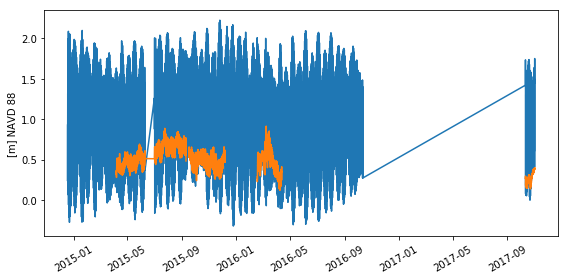

In [5]:
plt.figure(figsize=(8,4))
plt.plot(df.index,df['hocn'],'-')
plt.plot(df.index,df['h'],'-')
plt.xticks(rotation=30)
plt.ylabel('[m] NAVD 88')
plt.tight_layout()

#plt.plot(tg.index,tg['Water Level'])

Text(0.5, 0, '$\\Delta h$')

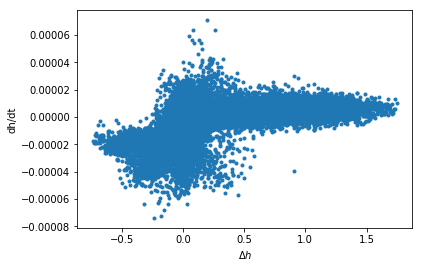

In [6]:
plt.figure()
#plt.plot(df['hocn']-df['h'],ts.hanning(df['dhdt'],8),'.')
plt.plot(df['hocn']-df['h'],df['dhdt'],'.')
plt.ylabel('dh/dt')
plt.xlabel('$\Delta h$')

In [7]:
repair_date = np.datetime64('2016-01-12')

In [8]:
#initiali, = np.where(df['DateTime'] < np.datetime64('2015-09-14'))
initiali, = np.where(df['DateTime'] < np.datetime64('2015-06-14'))


beforei, = np.where(df['DateTime'] < repair_date)
afteri, = np.where(df['DateTime'] > repair_date)

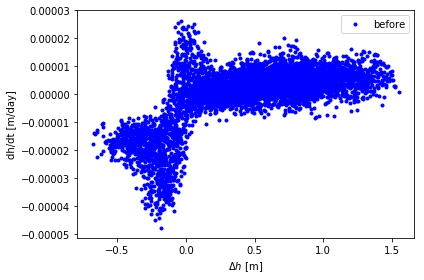

In [9]:
plt.figure()
#plt.plot(df['hocn']-df['h'],ts.hanning(df['dhdt'],8),'.')
plt.plot(df['hocn'][initiali]-df['h'][initiali],df['dhdt'][initiali],'b.')
plt.ylabel('dh/dt [m/day]')
plt.xlabel('$\Delta h$ [m]')
plt.legend(['before','after'])
plt.tight_layout()

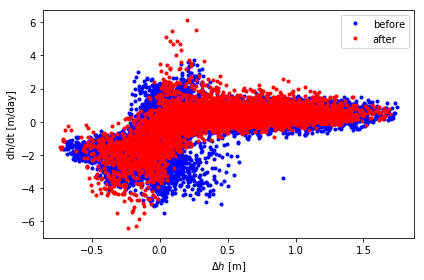

In [10]:
plt.figure()
#plt.plot(df['hocn']-df['h'],ts.hanning(df['dhdt'],8),'.')
plt.plot(df['hocn'][beforei]-df['h'][beforei],df['dhdt'][beforei]*86400,'b.')
plt.plot(df['hocn'][afteri]-df['h'][afteri],df['dhdt'][afteri]*86400,'r.')
plt.ylabel('dh/dt [m/day]')
plt.xlabel('$\Delta h$ [m]')
plt.legend(['before','after'])
plt.tight_layout()

In [11]:
# bin average by delta_h

In [12]:
delta_h_bins = np.arange(-1,2.5,0.1)
delta_h_bin_cen = 0.5*(delta_h_bins[:-1]+delta_h_bins[1:])

dhdt_mean = np.nan*np.ones(len(delta_h_bin_cen))
dhdt_std = np.nan*np.ones(len(delta_h_bin_cen))

dhdt_mean_initial = np.nan*np.ones(len(delta_h_bin_cen))
dhdt_std_initial = np.nan*np.ones(len(delta_h_bin_cen))

dhdt_mean_before = np.nan*np.ones(len(delta_h_bin_cen))
dhdt_std_before = np.nan*np.ones(len(delta_h_bin_cen))

dhdt_mean_after = np.nan*np.ones(len(delta_h_bin_cen))
dhdt_std_after = np.nan*np.ones(len(delta_h_bin_cen))

dhdt16_mean = np.nan*np.ones(len(delta_h_bin_cen))
dhdt16_std = np.nan*np.ones(len(delta_h_bin_cen))

for bini,(lower_bin,upper_bin) in enumerate(zip(delta_h_bins[:-1],delta_h_bins[1:])):
    bi, = np.where((df['delta_h']>lower_bin) & (df['delta_h']<upper_bin))
    dhdt_mean[bini] = np.nanmean(df['dhdt'][bi])
    dhdt_std[bini] = np.nanstd(df['dhdt'][bi])
    
    bi16, = np.where((d['delta_h']>lower_bin) & (d['delta_h']<upper_bin))
    dhdt16_mean[bini] = np.nanmean(d['dhdt'][bi16])
    dhdt16_std[bini] = np.nanstd(d['dhdt'][bi16])    

    bii, = np.where((df['delta_h'][initiali]>lower_bin) & (df['delta_h'][initiali]<upper_bin))
    dhdt_mean_initial[bini] = np.nanmean(df['dhdt'][initiali][bii])
    dhdt_std_initial[bini] = np.nanstd(df['dhdt'][initiali][bii])    
    
    bbi, = np.where((df['delta_h'][beforei]>lower_bin) & (df['delta_h'][beforei]<upper_bin))
    dhdt_mean_before[bini] = np.nanmean(df['dhdt'][beforei][bbi])
    dhdt_std_before[bini] = np.nanstd(df['dhdt'][beforei][bbi])
    
    bai, = np.where((df['delta_h'][afteri]>lower_bin) & (df['delta_h'][afteri]<upper_bin))
    dhdt_mean_after[bini] = np.nanmean(df['dhdt'][afteri][bai])
    dhdt_std_after[bini] = np.nanstd(df['dhdt'][afteri][bai])    

/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: Mean of empty slice
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in greater
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in less
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: Mean of empty slice
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: Mean of empty slice
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:33: Runt

Text(0.5, 0, '$\\Delta h$ [m]')

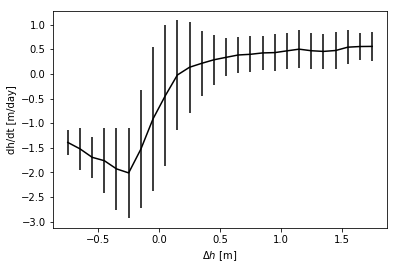

In [13]:
plt.figure()
plt.errorbar(delta_h_bin_cen,dhdt_mean*86400,dhdt_std*86400,color='k')
plt.ylabel('dh/dt [m/day]')
plt.xlabel('$\Delta h$ [m]')

Text(0.5, 0, '$\\Delta h$ [m]')

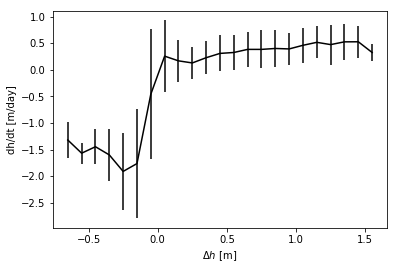

In [14]:
plt.figure()
plt.errorbar(delta_h_bin_cen,dhdt_mean_initial*86400,dhdt_std_initial*86400,color='k')
plt.ylabel('dh/dt [m/day]')
plt.xlabel('$\Delta h$ [m]')

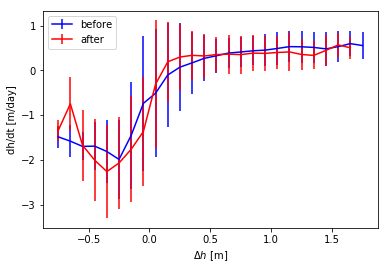

In [15]:
plt.figure()
plt.errorbar(delta_h_bin_cen,dhdt_mean_before*86400,dhdt_std_before*86400,color='b')
plt.errorbar(delta_h_bin_cen,dhdt_mean_after*86400,dhdt_std_after*86400,color='r')
plt.ylabel('dh/dt [m/day]')
plt.xlabel('$\Delta h$ [m]')
plt.legend(['before','after'])

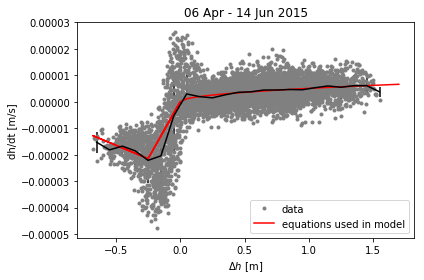

In [16]:
idx = initiali

# piecewise linear fit
ii1, = np.where((df['delta_h'][idx] < -0.25) & 
                (np.isfinite(df['delta_h'][idx]+df['dhdt'][idx])))
lr1 = stats.linregress(df['delta_h'][idx][ii1],df['dhdt'][idx][ii1])

ii2, = np.where((df['delta_h'][idx] > -0.25)&(df['delta_h'][idx] < 0) & 
                (np.isfinite(df['delta_h'][idx]+df['dhdt'][idx])))
lr2 = stats.linregress(df['delta_h'][idx][ii2],df['dhdt'][idx][ii2])

ii3, = np.where((df['delta_h'][idx] > 0) & (np.isfinite(df['delta_h'][idx]+df['dhdt'][idx])))
lr3 = stats.linregress(df['delta_h'][idx][ii3],df['dhdt'][idx][ii3])

def square_root(x,a):
    y = a*x**0.5
    return y

#ii0, = np.where((df['delta_h'][idx] <= 0) & 
#                (np.isfinite(df['delta_h'][idx]+df['dhdt'][idx])))
#popt0,pcov0 = curve_fit(square_root, df['delta_h'][idx][ii0], df['dhdt'][idx][ii0])
popt3,pcov3 = curve_fit(square_root, df['delta_h'][idx][ii3], df['dhdt'][idx][ii3])
#popt3,pcov3 = curve_fit(square_root, df['delta_h'][idx][ii3], df['dhdt'][idx][ii3])


plt.figure()
plt.plot(df['hocn'][idx]-df['h'][idx],df['dhdt'][idx],'.',color='gray')
plt.errorbar(delta_h_bin_cen,dhdt_mean_initial,dhdt_std_initial,color='k')
#plt.plot(df['delta_h'][idx][ii1],-0.000015*np.ones(len(df['delta_h'][idx][ii1])),'r-')
plt.plot(df['delta_h'][idx][ii1],df['delta_h'][idx][ii1]*lr1[0]+lr1[1],'r-')
#plt.plot(df['delta_h'][ii2],df['delta_h'][ii2]*lr2[0]+lr2[1],'r-')
plt.plot(df['delta_h'][idx][ii2],(lr1[0]*-0.25+lr1[1])*df['delta_h'][idx][ii2]/-0.25,'r-')
#plt.plot(df['delta_h'][idx][ii2],0.000015*df['delta_h'][idx][ii2]/0.25,'r-')
#plt.plot(df['delta_h'][ii3],df['delta_h'][ii3]*lr3[0]+lr3[1],'r-')
# x0 = np.arange(np.nanmin(df['delta_h']),0,0.05)
# plt.plot(x0,-np.abs(x0)**0.5*popt0[0],'r-')
x3 = np.arange(0,df['delta_h'].max(),0.05)
plt.plot(x3,x3**0.5*popt3[0],'r-')
plt.ylabel('dh/dt [m/s]')
plt.xlabel('$\Delta h$ [m]')
plt.title('06 Apr - 14 Jun 2015')
plt.tight_layout()
plt.legend(['data','equations used in model'])




estimated area =  156546.02514001002 m^2


/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less_equal
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater_equal
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less_equal
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either i

Text(0.5, 1.0, 'summer 2016')

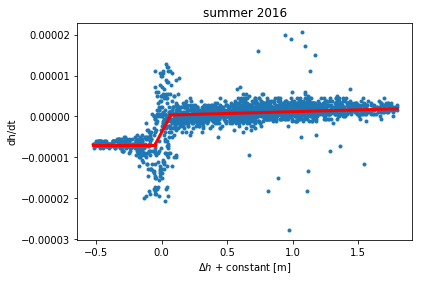

In [17]:
ipos = (d['hocn']-d['h']+0.75 > 0.065) \
        & (np.isfinite(d['hocn']+d['h']+d['Q']+d['dhdt']))
lrp = stats.linregress(d['hocn'][ipos]-d['h'][ipos]+0.75,d['Q'][ipos])

imid = (d['hocn']-d['h']+0.75 <= 0.065) \
        & (d['hocn']-d['h']+0.75 >= -0.05) \
        & (np.isfinite(d['hocn']+d['h']+d['Q']))
lrm = stats.linregress(d['hocn'][imid]-d['h'][imid]+0.75,d['Q'][imid])

ineg = (d['hocn']-d['h']+0.75 <= -0.05) & (np.isfinite(d['hocn']+d['h']+d['Q']))
mn = np.nanmean(d['Q'][ineg])

popt4,pcov4 = curve_fit(square_root, d['delta_h'][ipos], d['dhdt'][ipos])

fi, = np.where((np.isfinite(d['Q'])) & (np.isfinite(ts.hanning(d['dhdt'],4)))) 
slope,intercept,r,p,stderr = stats.linregress(d['Q'][fi],ts.hanning(d['dhdt'],4)[fi])

# regression of y on x
slopexy,interceptxy,r,p,stderrxy = stats.linregress(ts.hanning(d['dhdt'],4)[fi],d['Q'][fi])
slope2 = 1/slopexy
intercept2 = interceptxy/slopexy

relerr = stderr/slope

A = 1/slope
print('estimated area = ',A,'m^2')

xpos = np.array([0.065,np.nanmax(d['hocn']-d['h']+0.75)])
xmid = np.array([-0.05,0.065])
xneg = np.array([np.nanmin(d['hocn']-d['h']+0.75),-0.05])

plt.figure()
plt.plot(d['hocn']-d['h']+0.75,d['dhdt'],'.')
#plt.plot(xpos,lrp[0]/A*xpos+lrp[1]/A,'r-',lw=3)
plt.plot(xpos,popt4[0]*xpos**0.5,'r-',lw=3)
plt.plot(xmid,lrm[0]/A*xmid+lrm[1]/A,'r-',lw=3)
plt.plot(xneg,mn/A*np.ones(np.shape(xneg)),'r-',lw=3)
plt.xlabel('$\Delta h$ + constant [m]')
plt.ylabel('dh/dt')
plt.title('summer 2016')

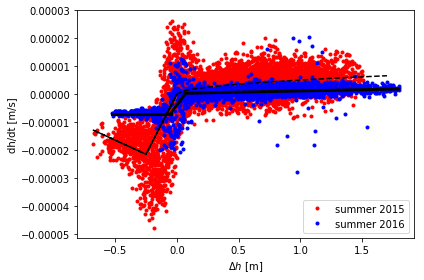

In [18]:
plt.figure()
plt.plot(df['hocn'][idx]-df['h'][idx],df['dhdt'][idx],'.',color='r')
plt.plot(d['hocn']-d['h']+0.75,d['dhdt'],'b.')
plt.legend(['summer 2015','summer 2016'])
# plt.errorbar(delta_h_bin_cen,dhdt_mean_initial,dhdt_std_initial,color='k')
# plt.errorbar(delta_h_bin_cen,dhdt16_mean,dhdt16_std,color='k')
plt.plot(df['delta_h'][idx][ii1],df['delta_h'][idx][ii1]*lr1[0]+lr1[1],'k--')
plt.plot(df['delta_h'][idx][ii2],(lr1[0]*-0.25+lr1[1])*df['delta_h'][idx][ii2]/-0.25,'k--')
#plt.plot(xpos,lrp[0]/A*xpos+lrp[1]/A,'k--',lw=3)
plt.plot(xpos,popt4[0]*xpos**0.5,'k-',lw=3)
plt.plot(xmid,lrm[0]/A*xmid+lrm[1]/A,'k-',lw=3)
plt.plot(xneg,mn/A*np.ones(np.shape(xneg)),'k-',lw=3)
x3 = np.arange(0,df['delta_h'].max(),0.05)
plt.plot(x3,x3**0.5*popt3[0],'k--')
plt.ylabel('dh/dt [m/s]')
plt.xlabel('$\Delta h$ [m]')
plt.tight_layout()

In [19]:
# time array (in seconds)
tstart = np.datetime64('2015-04-01')
tend = np.datetime64('2016-05-01')
ti, = np.where((tg.index >= tstart) & (tg.index < tend) & np.isfinite(tg['Water Level'])) 
dtime = tg.index[ti]
tocn = np.array(tg.index[ti])
hocn = np.array(tg['Water Level'][ti])

tnum = (np.array(tocn-tocn[0]))/np.timedelta64(1,'s')
t0 = 0
tend = tnum[-1] # total time in hocn series (seconds)
t = np.arange(t0,tend,3600)

#offset = 0.75

y0 = 0.4

In [20]:
def dhdt(h,t,hocn_vec,tocn_vec,lr1,lr2,popt3):  
    # interpolate ocean height to instantaneous time
    hocn = np.interp(t,tocn_vec,hocn_vec)    
    hdiff = hocn-h
    
    if hdiff < -0.25:
        dhdt = lr1[0]*hdiff+lr1[1]
        #dhdt = -0.00002
    elif hdiff >= -0.25 and hdiff < 0:
        dhdt = (lr1[0]*-0.25+lr1[1])*hdiff/-0.25
        #dhdt = -0.00002*hdiff/-0.25
    else:
        dhdt = popt3[0]*hdiff**0.5

    return dhdt

hmod = odeint(dhdt, y0, tnum, args=(hocn,tnum,lr1,lr2,popt3))

In [21]:
lrp = np.array([ 0.20248563,  0.0300536])
lrm = np.array([  9.38771217e+00,  -6.06432704e-01])
mn = -1.097548
A = 156546.025
offset = 0.75

# discharge as a function of water level difference between Monterey and M.C.
def Qfunc(hdiff):
    if hdiff > 0.065:
        Qf = A*popt4[0]*hdiff**0.5
    elif hdiff <= -0.05:
        Qf = mn
    else:
        Qf = lrm[0]*hdiff+lrm[1]
    return Qf

def dhdt_b(h,t,A,offset,hocn_vec,tocn_vec,lrp,lrm,mn,Qfunc):  
    # interpolate ocean height to instantaneous time
    hocn = np.interp(t,tocn_vec,hocn_vec)    
    hdiff = hocn-h
    
    Qf = Qfunc(hdiff)
        
    dhdt = Qf/A
    return dhdt

# discharge as a function of water level difference between Monterey and M.C.
def Qfunc2(hdiff):
    if hdiff > 0.065:
        Qf = 0.5*A*popt4[0]*hdiff**0.5
    elif hdiff <= -0.05:
        Qf = mn
    else:
        Qf = lrm[0]*hdiff+lrm[1]
    return Qf

def dhdt_c(h,t,A,offset,hocn_vec,tocn_vec,lrp,lrm,mn,Qfunc):  
    # interpolate ocean height to instantaneous time
    hocn = np.interp(t,tocn_vec,hocn_vec)    
    hdiff = hocn-h
    
    Qf = Qfunc2(hdiff)
        
    dhdt = Qf/A
    return dhdt

hmodb = odeint(dhdt_b, y0, tnum, args=(A,offset,hocn,tnum,lrp,lrm,mn,Qfunc))
hmodc = odeint(dhdt_c, y0, tnum, args=(A,offset,hocn,tnum,lrp,lrm,mn,Qfunc2))

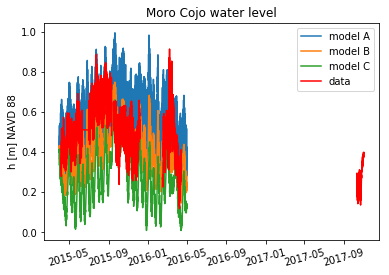

In [22]:
plt.figure()
plt.plot(dtime,hmod)
plt.plot(dtime,hmodb)
plt.plot(dtime,hmodc)
plt.plot(df['DateTime'],df['h'],'r-')
plt.xticks(rotation=15)
plt.title('Moro Cojo water level')
plt.ylabel('h [m] NAVD 88')
plt.legend(['model A','model B','model C','data'])

In [23]:
# time array (in seconds)
tstart = np.datetime64('1993-04-15')
tend = np.datetime64('1993-07-25')
ti, = np.where((tg.index >= tstart) & (tg.index < tend) & np.isfinite(tg['Water Level'])) 
dtime93 = tg.index[ti]
tocn93 = np.array(tg.index[ti])
hocn93 = np.array(tg['Water Level'][ti])

tnum93 = (np.array(tocn93-tocn93[0]))/np.timedelta64(1,'s')
t0 = 0
tend93 = tnum93[-1] # total time in hocn series (seconds)
t93 = np.arange(t0,tend93,3600)

#offset = 0.75

y0 = 0.4

def dhdt_d(h,t,hocn_vec,tocn_vec,lr1,lr2,popt3):  
    # interpolate ocean height to instantaneous time
    hocn = np.interp(t,tocn_vec,hocn_vec)    
    hdiff = hocn-h
    
    if hdiff < -0.25:
        dhdt = 1*(lr1[0]*hdiff+lr1[1])
        #dhdt = -0.000018
    elif hdiff >= -0.25 and hdiff < 0:
        dhdt = 1*((lr1[0]*-0.25+lr1[1])*hdiff/-0.25)
        #dhdt = -0.000018*hdiff/-0.25
    else:
        dhdt = 0.2*popt3[0]*hdiff**0.5

    return dhdt

hmod93a = odeint(dhdt, y0, tnum93, args=(hocn,tnum,lr1,lr2,popt3))
hmod93b = odeint(dhdt_b, y0, tnum93,  args=(A,offset,hocn,tnum,lrp,lrm,mn,Qfunc))

In [24]:
hmod93c = odeint(dhdt_c, y0, tnum93, args=(A,offset,hocn,tnum,lrp,lrm,mn,Qfunc2))
hmod93c_sl = odeint(dhdt_c, y0, tnum93, args=(A,offset,hocn+0.5,tnum,lrp,lrm,mn,Qfunc2))
#hmod93d = odeint(dhdt_d, y0, tnum, args=(A,offset,hocn,tnum,lrp,lrm,mn,Qfunc2))

Text(0, 0.5, 'h [feet]')

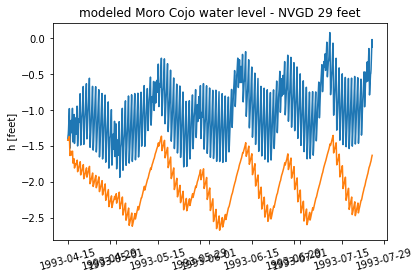

In [25]:
plt.figure()
plt.plot(dtime93,(hmod93a - 0.831)*3.2808)
#plt.plot(dtime,(hmod93b - 0.831)*3.2808)
plt.plot(dtime93,(hmod93c - 0.831)*3.2808)
#plt.plot(dtime,(hmod93c_sl - 0.831)*3.2808)
#plt.plot(dtime,(hmod93d - 0.831)*3.2808)
#plt.plot(df['DateTime'],df['h'],'r-')
plt.xticks(rotation=15)
plt.title('modeled Moro Cojo water level - NVGD 29 feet')
plt.ylabel('h [feet]')

Text(0, 0.5, 'h [m]')

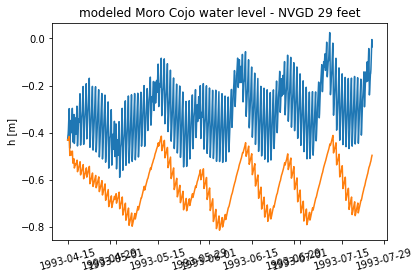

In [26]:
plt.figure()
plt.plot(dtime93,(hmod93a - 0.831))
#plt.plot(dtime,(hmod93b - 0.831)*3.2808)
plt.plot(dtime93,(hmod93c - 0.831))
#plt.plot(df['DateTime'],df['h'],'r-')
plt.xticks(rotation=15)
plt.title('modeled Moro Cojo water level - NVGD 29 feet')
plt.ylabel('h [m]')

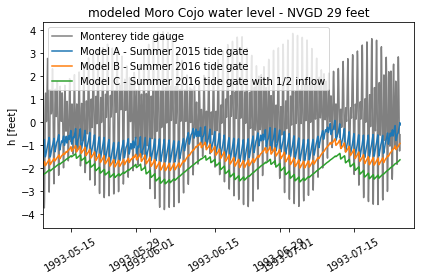

In [27]:
plt.figure()
plt.plot(dtime93,(hocn93-0.831)*3.2808,'gray')
plt.plot(dtime93,(hmod93a-0.831)*3.2808)
plt.plot(dtime93,(hmod93b-0.831)*3.2808)
plt.plot(dtime93,(hmod93c-0.831)*3.2808)
plt.title('modeled Moro Cojo water level - NVGD 29 feet')
plt.ylabel('h [feet]')
plt.xticks(rotation=30)
plt.xlim([np.datetime64('1993-05-09'),np.datetime64('1993-07-28')])
plt.legend(['Monterey tide gauge','Model A - Summer 2015 tide gate',
            'Model B - Summer 2016 tide gate',
            'Model C - Summer 2016 tide gate with 1/2 inflow'])
plt.tight_layout()